# AI Applications Project - Outlet Performance Classifier

<p>I will prepare and model a dataset to classify retail outlet performance as Good, Medium, or Poor. This classification aims to help sales merchandisers quickly identify and focus on underperforming outlets, enabling targeted actions to improve sales. </p>

<h2>Objectives:</h2>

- Load and explore dataset to understand its structure and key variables related to outlet performance
- Handle missing values and clean categorical variables to ensure data quality and consistency
- Engineer new features at the outlet level, including sales aggregates and operational metrics, to enrich the model input
- Define outlet performance labels (e.g. good, medium, poor) based on sales and operation thresholds
- Apply appropriate encoding and scaling techniques to prepare data for machine learning algorithms
- Train, validate, and evaluate classification models to predict outlet performance categories

<h2>What I hope to achieve:</h2>

- A clean, feature rich dataset suitable for classification
- A trained machine learning model that can reliably predict outlet performance categories 
- Actionable insights for business users to driver smarter, faster decisions


[Dataset link](https://data.niaid.nih.gov/resources?id=zenodo_6509954)


<h2>Step 1 - Import required libraries </h2>

In [7]:
!pip install -q numpy<2 pandas scikit-learn

The system cannot find the file specified.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt


<h2> Step 2 - Load/Understand the dataset </h2>

After exploring the dataset, I found that there are 14,204 entries with a mixture of numerical and categorical features. Columns Item_Weight and Column_size have 2,439 and 4,016 missing values respectively. I will be imputing these values as it is relatively small and will preserve as much data as possible for modeling. I also found that Item_Fat_Content had inconsistencies (e.g. "Low Fat", 'low fat", "LF") that will be standardized. Other categorical columns such as Item_Type and Outlet_Type has many categories which would require encoding. Overall, the dataset is comprehensive but requires data cleaning and preprocessing to handle missing values and categorical inconsistencies.

In [4]:
import requests
import zipfile
import io
import pandas as pd

url = "https://zenodo.org/records/6509955/files/data.csv?download=1"

# Load CSV directly from URL
df = pd.read_csv(url)

# Display first few rows
df.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
# Shape of dataset
print("Rows and Columns:", df.shape)

# Check basic info about the dataset (rows, columns, data types, non-null counts)
print("Dataset Info:")
df.info()


Rows and Columns: (14204, 12)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          14204 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


In [8]:
# Summary statistics for numeric columns
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,14204.000000
mean,12.792854,0.065953,141.004977,1997.830681,2099.333529
std,4.652502,0.051459,62.086938,8.371664,1542.432736
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,878.856000
50%,12.600000,0.054021,142.247000,1999.000000,1828.273366
75%,16.750000,0.094037,185.855600,2004.000000,2949.298043
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [10]:
# Check for missing values per column
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [12]:
# Count unique values for categorical columns
categorical_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Type']
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())


Value counts for Item_Fat_Content:
Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: count, dtype: int64

Value counts for Item_Type:
Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: count, dtype: int64

Value counts for Outlet_Type:
Outlet_Type
Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: count, dtype: int64


<h2>Distribution of Item Outlet Sales</h2>

The histogram shows that most outlets have low to medium sales and only a few have high sales. As the sales numbers are not spread out evenly and have many small values and a few big ones, it makes sense to group sales into categories like Poor, Medium, and Good. This way, the model can focus on classifying outlets into these groups instead of trying to predict exact sales numbers, which is easier and more reliable.

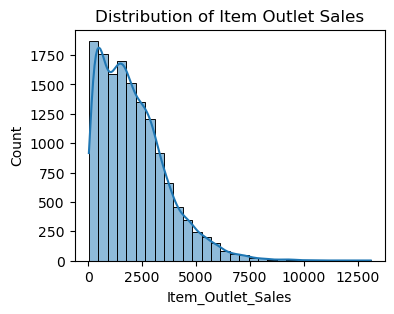

In [15]:
# Distribution of target variable
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.histplot(df['Item_Outlet_Sales'], bins=30, kde=True)
plt.title('Distribution of Item Outlet Sales')
plt.xlabel('Item_Outlet_Sales')
plt.ylabel('Count')
plt.show()

In [17]:
# Number of unique items
num_unique_items = df['Item_Identifier'].nunique()

# Number of unique outlets
num_unique_outlets = df['Outlet_Identifier'].nunique()

print(f"Number of unique items: {num_unique_items}")
print(f"Number of unique outlets: {num_unique_outlets}")

Number of unique items: 1559
Number of unique outlets: 10


<h2>Step 3 - Data Preparation </h2>

In [20]:
# Standardize inconsistent labels to unify categories
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})

# Fill missing 'Item_Weight' values with the median weight of the same 'Item_Identifier'
df['Item_Weight'] = df.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.median()))

# For any remaining missing 'Item_Weight' values (if item median not available), fill with overall median
df['Item_Weight'].fillna(df['Item_Weight'].median(), inplace=True)

# Fill missing 'Outlet_Size' values with the mode size corresponding to their 'Outlet_Type'
mode_outlet_size = df.groupby('Outlet_Type')['Outlet_Size'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Medium')
df['Outlet_Size'] = df.apply(lambda row: mode_outlet_size[row['Outlet_Type']] if pd.isnull(row['Outlet_Size']) else row['Outlet_Size'], axis=1)

C:\Users\ayura\AppData\Local\Temp\ipykernel_9616\2312740040.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Item_Weight'].fillna(df['Item_Weight'].median(), inplace=True)


<h3>Feature Engineering</h3>

In [23]:
# Calculate how old each outlet is (assuming current year is 2025)
df['Outlet_Age'] = 2025 - df['Outlet_Establishment_Year']



# Calculate average Item_Visibility ignoring zeros (which are likely errors)
mean_visibility = df.loc[df['Item_Visibility'] > 0, 'Item_Visibility'].mean()
# Replace zero visibility values with the average visibility to correct data errors
df['Item_Visibility'] = df['Item_Visibility'].replace(0, mean_visibility)



# Calculate the average sales per item across all outlets
item_avg_sales = df.groupby('Item_Identifier')['Item_Outlet_Sales'].transform('mean')
# Calculate sales deviation for each item in each row from its average sales
df['Item_Sales_Deviation'] = df['Item_Outlet_Sales'] - item_avg_sales

In [25]:
# Function to categorize sales into performance classes
def classify_performance(sales):
    if sales < 1000:
        return 0  # Poor
    elif sales < 3000:
        return 1  # Medium
    else:
        return 2  # Good

# Apply the function to 'Item_Outlet_Sales' column to create a new categorical target column
# Performance_Label will be used as the classification target in the model
df['Performance_Label'] = df['Item_Outlet_Sales'].apply(classify_performance)

# After applying the new function, run this again to see the new distribution:
print(df['Performance_Label'].value_counts())


Performance_Label
1    6823
0    3962
2    3419
Name: count, dtype: int64


In [27]:
# Drop unnecessary columns
df = df.drop(columns=['Item_Identifier', 'Outlet_Establishment_Year'], errors='ignore')


<h3>Categorical and Numerical Feature Encoding</h3>

Define columns by type for appropriate encoding:
- one_hot_encode_cols: categorical variables without inherent order, to be one-hot encoded
- ordinal_encode_cols: categorical variables with meaningful order, to be ordinal encoded
- numeric_cols: continuous numerical features to be used as-is

In [30]:
# Define columns
one_hot_encode_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Type']
ordinal_encode_cols = ['Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type']
numeric_cols = ['Item_Visibility', 'Item_Weight', 'Item_MRP', 'Outlet_Age', 'Item_Sales_Deviation']


# Combine all feature columns into a single list for model input
feature_cols = one_hot_encode_cols + ordinal_encode_cols + numeric_cols

#Extract feature and matrix X and target vector y
X = df[feature_cols]
y = df['Performance_Label']


<h3>Preprocessing and pipeline</h3>

- OneHotEncoder applied to specified categorical columns without order
- OrdinalEncoder applied to specified categorical columns with order
- All other columns (numeric) passed through unchanged

Built a preprocessing and modeling pipeline that automatically handles encoding of categorical features. By combining these transformations with the Random Forest Classifier in a single pipeline object, it ensures consistency and error-free processing of training and testing data. Using a pipeline simplifies the workflow, prevents data leakage by fitting encoders only on training data, and makes the code easier to maintain and deploy.

In [33]:
# Set up preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_encode_cols),
        ('ordinal', OrdinalEncoder(), ordinal_encode_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline that first preprocesses the data, then fits a Random Forest classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


<h3>Split into training set and test set</h3>

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [65]:
print(X_train)

      Item_Fat_Content              Item_Type        Outlet_Type  \
4099           Low Fat  Fruits and Vegetables  Supermarket Type1   
727            Regular           Frozen Foods  Supermarket Type1   
3591           Regular           Frozen Foods  Supermarket Type1   
2692           Regular                 Breads      Grocery Store   
5546           Low Fat                 Canned  Supermarket Type3   
...                ...                    ...                ...   
12731          Low Fat                 Canned      Grocery Store   
14030          Regular  Fruits and Vegetables  Supermarket Type1   
8470           Regular                   Meat  Supermarket Type1   
2623           Low Fat            Snack Foods  Supermarket Type1   
5784           Regular  Fruits and Vegetables      Grocery Store   

      Outlet_Identifier Outlet_Size Outlet_Location_Type  Item_Visibility  \
4099             OUT013        High               Tier 3         0.008757   
727              OUT049      

In [67]:
print(X_test)

      Item_Fat_Content     Item_Type        Outlet_Type Outlet_Identifier  \
6727           Low Fat  Baking Goods  Supermarket Type1            OUT017   
13606          Low Fat     Household  Supermarket Type1            OUT013   
7174           Regular         Dairy  Supermarket Type1            OUT013   
10526          Regular        Canned  Supermarket Type1            OUT035   
7668           Low Fat     Household  Supermarket Type1            OUT013   
...                ...           ...                ...               ...   
7264           Low Fat   Hard Drinks  Supermarket Type1            OUT035   
11940          Low Fat     Household  Supermarket Type1            OUT013   
12034          Low Fat  Baking Goods  Supermarket Type1            OUT046   
2293           Low Fat   Snack Foods  Supermarket Type1            OUT045   
3178           Low Fat  Frozen Foods  Supermarket Type1            OUT045   

      Outlet_Size Outlet_Location_Type  Item_Visibility  Item_Weight  \
672

In [69]:
print(y_train)

4099     1
727      0
3591     0
2692     0
5546     1
        ..
12731    0
14030    1
8470     1
2623     1
5784     0
Name: Performance_Label, Length: 11363, dtype: int64


In [71]:
print(y_test)

6727     1
13606    1
7174     1
10526    2
7668     2
        ..
7264     1
11940    1
12034    1
2293     2
3178     0
Name: Performance_Label, Length: 2841, dtype: int64


<h2> Step 4 - Train and evaluate</h2>

After training the model, it is evaluated on the test set, achieving an overall accuracy of 89%. The detailed classification report shows strong performance across all classes, with precision, recall, and F1-scores ranging between 0.82 and 0.96. This indicates the model effectively distinguishes between Poor, Medium, and Good sales performance categories, demonstrating reliable predictive capability on unseen data.

In [39]:
# Train model
pipeline.fit(X_train, y_train)


C:\Users\ayura\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Item_Fat_Content',
                                                   'Item_Type',
                                                   'Outlet_Type']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Outlet_Identifier',
                                                   'Outlet_Size',
                                                   'Outlet_Location_Type'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [41]:
# Evaluate model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.87      0.91       792
           1       0.86      0.95      0.90      1365
           2       0.93      0.84      0.88       684

    accuracy                           0.90      2841
   macro avg       0.92      0.89      0.90      2841
weighted avg       0.90      0.90      0.90      2841



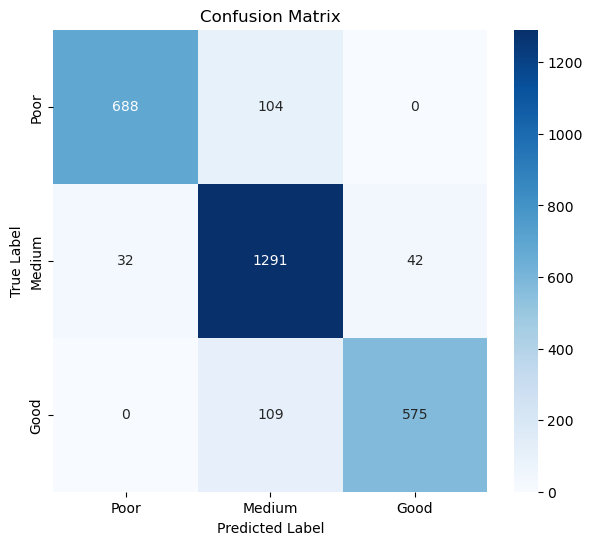

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# True and predicted labels
y_true = y_test
y_pred = pipeline.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class names for labels
class_names = ['Poor', 'Medium', 'Good']

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


<h3>From previous training</h3>

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       792
           1       0.85      0.94      0.89      1365
           2       0.92      0.83      0.87       684

    accuracy                           0.89      2841
    macro avg       0.91      0.87      0.89      2841
    weighted avg       0.89      0.89      0.89      2841

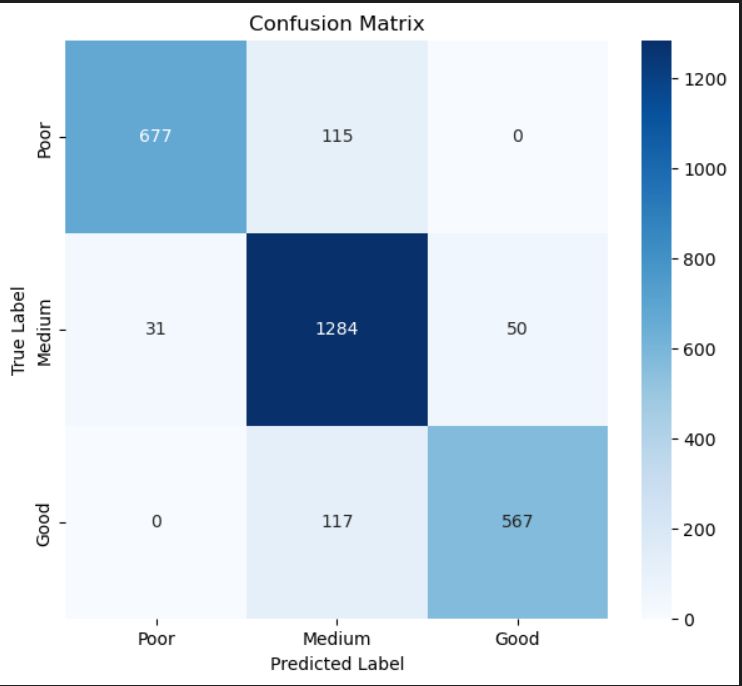

<h3>Predict Outlet Performance</h3>

To predict the performance of each outlet, the trained pipeline is used to classify the sales performance of every item. The most frequented predicted category is then chosen as the outlet's overall performance label. The results show a range of outlet performances, from Poor to Good, with most outlets falling into the Medium category. This insight provides clear understanding of outlet-level performance, enabling more informed business decisions and resource allocation.

In [46]:
# Predict using the pipeline (handles preprocessing internally)
df['Predicted_Label'] = pipeline.predict(X)

# Group predictions by each unique outlet identifier
# For each outlet, find the most common predicted label among all items sold there
outlet_performance = df.groupby('Outlet_Identifier')['Predicted_Label'].agg(
    lambda x: x.value_counts().idxmax() # Select the label with the highest frequency (mode) per outlet
).reset_index()

# Convert numeric prediction labels back to readable performance categories
label_map = {0: 'Poor', 1: 'Medium', 2: 'Good'}
outlet_performance['Outlet_Performance'] = outlet_performance['Predicted_Label'].map(label_map)

outlet_performance.sort_values(by='Outlet_Performance')


,Outlet_Identifier,Predicted_Label,Outlet_Performance
5,OUT027,2,Good
1,OUT013,1,Medium
2,OUT017,1,Medium
3,OUT018,1,Medium
6,OUT035,1,Medium
7,OUT045,1,Medium
8,OUT046,1,Medium
9,OUT049,1,Medium
0,OUT010,0,Poor
4,OUT019,0,Poor


In [82]:
import joblib

# Assuming 'pipeline' is the name of your trained scikit-learn Pipeline object
joblib.dump(pipeline, 'AAPOutletFinalfinal.joblib')

['AAPOutletFinalfinal.joblib']